In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
dataset_dir_path = '../dataset/WikiQACorpus/'
train_path = dataset_dir_path + 'WikiQA-train.tsv'
test_path = dataset_dir_path + 'WikiQA-test.tsv'
dev_path = dataset_dir_path + 'WikiQA-dev.tsv'


In [21]:
train_df = pd.read_csv(train_path, sep='\t', header=None)
test_df = pd.read_csv(test_path, sep='\t', header=None)
dev_df = pd.read_csv(dev_path, sep='\t', header=None)

In [22]:
train_df.shape


(20348, 7)

In [23]:
# store all sentences according to question with theri labels
train_dict = {}

for i in range(len(train_df)):
    q = train_df.iloc[i, 1]
    if q not in train_dict:
        train_dict[q] = [[train_df.iloc[i, 5], train_df.iloc[i, 6]]]
    else:
        train_dict[q].append([train_df.iloc[i, 5], train_df.iloc[i, 6]])

# delete a key from dictionary
del train_dict['Question']
# store all sentences according to question with theri labels
test_dict = {}

for i in range(len(test_df)):
    q = test_df.iloc[i, 1]
    if q not in test_dict:
        test_dict[q] = [[test_df.iloc[i, 5], test_df.iloc[i, 6]]]
    else:
        test_dict[q].append([test_df.iloc[i, 5], test_df.iloc[i, 6]])

del test_dict['Question']

# store all sentences according to question with theri labels

dev_dict = {}

for i in range(len(dev_df)):
    q = dev_df.iloc[i, 1]
    if q not in dev_dict:
        dev_dict[q] = [[dev_df.iloc[i, 5], dev_df.iloc[i, 6]]]
    else:
        dev_dict[q].append([dev_df.iloc[i, 5], dev_df.iloc[i, 6]])

del dev_dict['Question']

In [25]:
def transform_labels(dic):
    no_answer_keys = []
    for k in dic:
        sum = 0
        for i in range(len(dic[k])):
            sum += int(dic[k][i][1])
        if sum == 0:
            no_answer_keys.append(k)
            continue
    # delete no answer questions
    for k in no_answer_keys:
        del dic[k]
    
    return dic


train_dict = transform_labels(train_dict)
test_dict = transform_labels(test_dict)
dev_dict = transform_labels(dev_dict)


In [26]:
for k in train_dict:
    print(train_dict[k])
    break

    

[['A partly submerged glacier cave on Perito Moreno Glacier .', '0'], ['The ice facade is approximately 60 m high', '0'], ['Ice formations in the Titlis glacier cave', '0'], ['A glacier cave is a cave formed within the ice of a glacier .', '1'], ['Glacier caves are often called ice caves , but this term is properly used to describe bedrock caves that contain year-round ice.', '0']]


In [27]:
# create a list of (question,candidates) tuples
def create_qc_ql(dic):
    q_c_list = []
    for k in dic:
        for c in dic[k]:
            q_c_list.append((k, c[0]))
    
    q_l__list = []
    for k in dic:
        for c in dic[k]:
            q_l__list.append((k, c[1]))
            
    
    return q_c_list, q_l__list

train_q_c_list, train_q_l_list = create_qc_ql(train_dict)
test_q_c_list, test_q_l_list = create_qc_ql(test_dict)
dev_q_c_list, dev_q_l_list = create_qc_ql(dev_dict)



In [29]:
train_q_l_list = np.array(train_q_l_list)
test_q_l_list = np.array(test_q_l_list)
dev_q_l_list = np.array(dev_q_l_list)

In [10]:
# get cls token embedding from bert model by passing  [cls] [question] [sep] [candidate] [sep]
from transformers import BertTokenizer, BertModel
import torch


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

def get_cls_embedding(q_c_list):
    cls_embeddings = []
    for q_c in q_c_list:
        q = q_c[0]
        c = q_c[1]
        tokenized = tokenizer.encode(q, c, add_special_tokens=True)
        
        input_ids = torch.tensor([tokenized])
        with torch.no_grad():
            last_hidden_states = model(input_ids)[0]  # Models outputs are now tuples
        cls_embeddings.append(last_hidden_states[0][0].numpy())
    return cls_embeddings

train_cls_embeddings = get_cls_embedding(train_q_c_list)


/home/night_crwlr/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]


In [8]:
# save list as a pickle file and load
import pickle
import numpy as np

def save_pickle(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)


In [9]:
train_cls_embeddings = load_pickle('train_cls_embeddings.pkl')
train_cls_embeddings = np.array(train_cls_embeddings)

In [10]:
# Find score for each candidate using pytorch model

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class BertBaseline(nn.Module):
    def __init__(self):
        super(BertBaseline, self).__init__()
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 2)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


/home/night_crwlr/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
train_cls_embeddings.shape

(8666, 768)

In [14]:
# different losses in nn
# https://pytorch.org/docs/stable/nn.html#loss-functions


In [15]:
# train train_cls_embeddings on bert baseline using train_q_l as labels
# test on dev_cls_embeddings and test_cls_embeddings

# train

def train(epochs=10):
    classifier_model = BertBaseline()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier_model.parameters(), lr=0.001)

    # train and store losses and print for each epoch with batch = 64
    train_losses = []
    dev_losses = []
    test_losses = []

    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i in range(0, len(train_cls_embeddings), 64):
            # get the inputs; data is a list of [inputs, labels]
            inputs = train_cls_embeddings[i:i+64]
            inputs = torch.tensor(inputs, dtype=torch.float32)
            
            labels = train_q_l_list[i:i+64,1].astype(float)
            labels = torch.tensor(labels, dtype=torch.float32)

            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = classifier_model(inputs)
            
            
            loss = criterion(outputs, labels.type(torch.LongTensor))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        train_losses.append(running_loss)
        print('epoch: %d, loss: %.3f' %
                (epoch + 1, running_loss))

    print('Finished Training')
    return classifier_model

# test model on dev and test set

def get_loss(classifier_model,cls_embeddings, q_l_list):
    criterion = nn.CrossEntropyLoss()
    classifier_model.eval()
    
    running_loss = 0.0
    for i in range(0, len(cls_embeddings), 64):
        # get the inputs; data is a list of [inputs, labels]
        inputs = cls_embeddings[i:i+64]
        inputs = torch.tensor(inputs, dtype=torch.float32)
        
        labels = q_l_list[i:i+64,1].astype(float)
        labels = torch.tensor(labels, dtype=torch.float32)

        # forward + backward + optimize
        outputs = classifier_model(inputs)
        loss = criterion(outputs, labels.type(torch.LongTensor))
        running_loss += loss.item()
    
    classifier_model.train()
    return running_loss
    

In [30]:
# get embeddings from local computer 
dev_cls_embeddings = load_pickle('dev_cls_embeddings.pkl')
dev_cls_embeddings = np.array(dev_cls_embeddings)

test_cls_embeddings = load_pickle('test_cls_embeddings.pkl')
test_cls_embeddings = np.array(test_cls_embeddings)

In [17]:
test_cls_embeddings.shape

(2318, 768)

In [31]:
all_epochs = [1,2,3,4,5,10,15,20,25,50,100]
all_classifier_models = []
all_train_losses = []
all_dev_losses = []
all_test_losses = []

for epochs in all_epochs:
    classifier_model = train(epochs)
    all_classifier_models.append(classifier_model)
    train_loss = get_loss(classifier_model, train_cls_embeddings, train_q_l_list)
    all_train_losses.append(train_loss)
    dev_loss = get_loss(classifier_model, dev_cls_embeddings, dev_q_l_list)
    all_dev_losses.append(dev_loss)
    test_loss = get_loss(classifier_model, test_cls_embeddings, test_q_l_list)
    all_test_losses.append(test_loss)

epoch: 1, loss: 43.246
Finished Training
epoch: 1, loss: 43.110
epoch: 2, loss: 39.286
Finished Training
epoch: 1, loss: 42.953
epoch: 2, loss: 39.273
epoch: 3, loss: 37.741
Finished Training
epoch: 1, loss: 42.907
epoch: 2, loss: 39.163
epoch: 3, loss: 37.534
epoch: 4, loss: 36.176
Finished Training
epoch: 1, loss: 43.227
epoch: 2, loss: 39.309
epoch: 3, loss: 37.836
epoch: 4, loss: 36.599
epoch: 5, loss: 35.382
Finished Training
epoch: 1, loss: 42.980
epoch: 2, loss: 39.251
epoch: 3, loss: 37.751
epoch: 4, loss: 36.423
epoch: 5, loss: 35.349
epoch: 6, loss: 34.192
epoch: 7, loss: 32.960
epoch: 8, loss: 31.522
epoch: 9, loss: 30.269
epoch: 10, loss: 29.139
Finished Training
epoch: 1, loss: 42.981
epoch: 2, loss: 39.122
epoch: 3, loss: 37.603
epoch: 4, loss: 36.186
epoch: 5, loss: 34.984
epoch: 6, loss: 33.765
epoch: 7, loss: 32.431
epoch: 8, loss: 31.094
epoch: 9, loss: 30.053
epoch: 10, loss: 28.549
epoch: 11, loss: 27.048
epoch: 12, loss: 25.454
epoch: 13, loss: 24.025
epoch: 14, lo

In [32]:
# print all losses
for i in range(len(all_epochs)):
    print('Epochs: %d, Train Loss: %.3f, Dev Loss: %.3f, Test Loss: %.3f' %
                (all_epochs[i], all_train_losses[i], all_dev_losses[i], all_test_losses[i]))
                

Epochs: 1, Train Loss: 39.194, Dev Loss: 5.121, Test Loss: 11.460
Epochs: 2, Train Loss: 37.405, Dev Loss: 5.099, Test Loss: 11.330
Epochs: 3, Train Loss: 36.265, Dev Loss: 5.156, Test Loss: 11.342
Epochs: 4, Train Loss: 35.277, Dev Loss: 5.278, Test Loss: 11.476
Epochs: 5, Train Loss: 34.729, Dev Loss: 5.322, Test Loss: 11.574
Epochs: 10, Train Loss: 30.805, Dev Loss: 6.113, Test Loss: 12.896
Epochs: 15, Train Loss: 24.738, Dev Loss: 6.928, Test Loss: 14.496
Epochs: 20, Train Loss: 23.907, Dev Loss: 7.676, Test Loss: 16.224
Epochs: 25, Train Loss: 14.258, Dev Loss: 8.446, Test Loss: 18.220
Epochs: 50, Train Loss: 10.174, Dev Loss: 12.758, Test Loss: 28.782
Epochs: 100, Train Loss: 0.916, Dev Loss: 20.931, Test Loss: 43.745


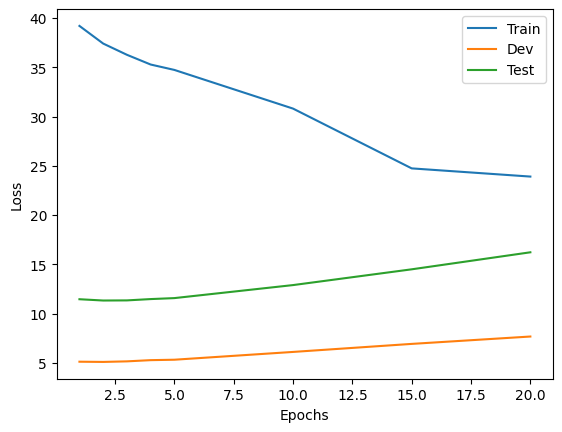

In [33]:
# plot all losses
import matplotlib.pyplot as plt

plt.plot(all_epochs[:8], all_train_losses[:8], label='Train')
plt.plot(all_epochs[:8], all_dev_losses[:8], label='Dev')
plt.plot(all_epochs[:8], all_test_losses[:8], label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [34]:
classifier_10_epochs = all_classifier_models[5]

In [36]:
def metric(classifier_model,qcl_dict,cls_embeddings,q_l_list):
    precisions = []
    ranks = []
    classifier_model.eval()
    for k in qcl_dict:
        question = k
        
        question_cls_embeddings = cls_embeddings[q_l_list[:,0] == question]
        question_cls_embeddings = torch.tensor(question_cls_embeddings, dtype=torch.float32)

        question_real_labels = q_l_list[q_l_list[:,0] == question,1].astype(int)

        
        # get indices where question_real_labels are 1
        question_real_labels_indices = np.where(question_real_labels == 1)[0]
        
        question_predicted_scores = classifier_model(question_cls_embeddings)
        # apply softmax to get probabilities
        question_predicted_scores = torch.nn.functional.softmax(question_predicted_scores, dim=1)
        question_predicted_scores = question_predicted_scores[:,1] - question_predicted_scores[:,0]
        question_predicted_scores = question_predicted_scores.detach().numpy()
        # sort the indices using scores
        sorted_indices = np.argsort(question_predicted_scores)[::-1]
        
        # change values in sorted_indices to -1 if they are in question_real_labels_indices
        for i in range(len(sorted_indices)):
            if sorted_indices[i] in question_real_labels_indices:
                sorted_indices[i] = -1
        
        precision = 0
        rank = 0
        c = 0
        for i,ind in enumerate(sorted_indices):
            if ind == -1:
                rank  = 1/(i+1)
                c += 1
                precision += (c/(i+1))
        
        precision = precision/c
        precisions.append(precision)
        ranks.append(rank)
    classifier_model.train()
    return np.mean(precisions), np.mean(ranks)

        

    

In [37]:

train_MAP, train_MRR = metric(classifier_10_epochs, train_dict, train_cls_embeddings, train_q_l_list)
dev_MAP, dev_MRR = metric(classifier_10_epochs, dev_dict, dev_cls_embeddings, dev_q_l_list)
test_MAP, test_MRR = metric(classifier_10_epochs, test_dict, test_cls_embeddings, test_q_l_list)

print('Train MAP: %.3f, Train MRR: %.3f' % (train_MAP, train_MRR))
print('Dev MAP: %.3f, Dev MRR: %.3f' % (dev_MAP, dev_MRR))
print('Test MAP: %.3f, Test MRR: %.3f' % (test_MAP, test_MRR))

Train MAP: 0.788, Train MRR: 0.720
Dev MAP: 0.736, Dev MRR: 0.707
Test MAP: 0.693, Test MRR: 0.630


In [38]:
# print MAP and MRR for all epochs and for train, dev and test
for i in range(len(all_epochs)):
    train_MAP, train_MRR = metric(all_classifier_models[i], train_dict, train_cls_embeddings, train_q_l_list)
    dev_MAP, dev_MRR = metric(all_classifier_models[i], dev_dict, dev_cls_embeddings, dev_q_l_list)
    test_MAP, test_MRR = metric(all_classifier_models[i], test_dict, test_cls_embeddings, test_q_l_list)
    print('Epochs: %d, Train MAP: %.3f, Train MRR: %.3f, Dev MAP: %.3f, Dev MRR: %.3f, Test MAP: %.3f, Test MRR: %.3f' %
                (all_epochs[i], train_MAP, train_MRR, dev_MAP, dev_MRR, test_MAP, test_MRR))

Epochs: 1, Train MAP: 0.686, Train MRR: 0.625, Dev MAP: 0.708, Dev MRR: 0.679, Test MAP: 0.691, Test MRR: 0.627
Epochs: 2, Train MAP: 0.699, Train MRR: 0.637, Dev MAP: 0.723, Dev MRR: 0.693, Test MAP: 0.696, Test MRR: 0.632
Epochs: 3, Train MAP: 0.706, Train MRR: 0.643, Dev MAP: 0.734, Dev MRR: 0.703, Test MAP: 0.702, Test MRR: 0.638
Epochs: 4, Train MAP: 0.719, Train MRR: 0.655, Dev MAP: 0.739, Dev MRR: 0.709, Test MAP: 0.706, Test MRR: 0.641
Epochs: 5, Train MAP: 0.721, Train MRR: 0.657, Dev MAP: 0.731, Dev MRR: 0.702, Test MAP: 0.703, Test MRR: 0.639
Epochs: 10, Train MAP: 0.788, Train MRR: 0.720, Dev MAP: 0.736, Dev MRR: 0.707, Test MAP: 0.693, Test MRR: 0.630
Epochs: 15, Train MAP: 0.852, Train MRR: 0.780, Dev MAP: 0.727, Dev MRR: 0.704, Test MAP: 0.672, Test MRR: 0.613
Epochs: 20, Train MAP: 0.891, Train MRR: 0.817, Dev MAP: 0.687, Dev MRR: 0.660, Test MAP: 0.658, Test MRR: 0.595
Epochs: 25, Train MAP: 0.938, Train MRR: 0.860, Dev MAP: 0.693, Dev MRR: 0.669, Test MAP: 0.665, Test